# Codes for Efficient Transmission of Data

## Introduction 

When sending packets of data over a communication channel such as the internet or a radio channel, packets often get erased. Because of this, packets must be sent under some erasure code such that the data can still be recovered. In CS 70, you may have learned about an erasure code that involves embedding the data in a polynomial, and then sampling points from that polynomial. There, we assumed that there were at most $k$ erasures in the channel. This week, we'll explore a different channel model in which each packet independently has a probability $p$ of being erased. In particular, this lab will look at random bipartite graphs (the balls and bins model).

A little more on the channel and the erasure code; formally, our channel is called the binary erasure channel (BEC), where bits that are sent through a noisy channel either make it through unmodified or are tagged as "corrupt", in which case the received information is dropped in all further information processing steps. Here's an image that shows what happens:

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Binary_erasure_channel.svg/156px-Binary_erasure_channel.svg.png"></center>

If we wanted to convey a message, we could consider a feedback channel in which the receiver tells the sender which messages were received and the sender re-sends the dropped packets. This process can be repeated until the receiver gets all of the intended message. While this procedure is indeed optimal in all senses of the word, feedback is simply not possible in many circumstances. If Netflix is trying to stream a show chunked into $n$ data chunks to a million people, its servers can't process all the feedback from the users. Thus, Netflix must use a method independent of feedback. If they use near-optimal codes to encode and constantly send out the same random chunks of the video's data to all users, then they can be sure that users get what they need in only a little more than $n$ transmissions *no matter what parts of the show each individual user lost through their specific channel*!

So what's the secret to this magic?  It's a two step process of clever encoding and decoding:

### Encoding
1. Suppose your data can be divided into $n$ chunks. First, pick an integer $d$ ($1 \leq d \leq n$) according to some distribution.
2. With $d$ picked, now select $d$ random chunks of the data and combine their binary representations together using the XOR operator.
3. Transmit these chunks, along with the metadata telling which actual chunk indices were XOR'd, as a packet. If a packet is erased, both the chunks it contains and the chunk indices would be lost. 

### Decoding
1. For each packet that has been received, check if it only contains one chunk, in which case the packet is exactly equal to the single chunk it contains. If not, we can check if any of the chunks in the packet are already known, in which case XOR that chunk with the packet and remove it from the list of chunk indices that make up the packet.
3. If there are two or more indices in the list left for the packet, we cannot figure out any more information!  Put it on the side for looking at later.
4. With any newly decoded information, we may be able to decode previously undecodable packets that we had put on the side.  Go through all unsolved packets and try to decode more packets until nothing more can be done.
5. Wait for the next packet to come and repeat!

Now what's left for you to do?  Well, remember that number $d$?  It needs to be picked according to some distribution, and which distribution is the million dollar question!


### Example
<center><img src="bipartite.png" style="width: 300px;"> </center>

Consider the above bipartite graph. Here, the right square nodes represent the packets, and the left circular nodes represent the data chunks ($X_i, i=1,..,4$). There is an edge from a packet to a chunk if the packet contains that chunk. Let's try decoding the packets chronologically.
1. Since the first packet contains only the third data chunk, we are able to immediately resolve it and find that $X_3=1$.
2. The second packet contains the second and third chunks XOR'd together. Since we already know the third chunk, we can XOR the third chunk ($X_3=1$) with the data packet (0) to get the value of the second data chunk, $X_2=1$.
3. The third packet contains the XOR of data chunks 1, 2, and 4. We have already determined chunks 2 and 3, so we are able to XOR 2 from this packet, but are still left with 1 and 4, and so must move on.
4. With the arrival of the fourth packet, we are able to resolve everything: data chunks 2 and 3 are already determined, and so we are able to XOR chunk 3 ($X_3=1$) with this new data packet (1) to get the value of the chunk 4, $X_4=0$. With this new information, we are able to resolve $X_1$, as packet 3 gave us the equation $1 = X_1 \oplus X_2 \oplus X_4 = X_1 \oplus 1 \oplus 0$. We can solve this to get $X_1 = 0$.
5. We have now solved for all the data chunks, with $X_1 = 0, X_2 = 1, X_3 = 1, X_4 = 0$.

As you might be able to tell, by choosing a good degree distribution for $d$, even when random incoming packets were lost (not shown), you were still able to recover all $4$ symbols only from $4$ received packets, despite the sender not knowing what packets you lost through the BEC.

## Q1. Code

We've provided you with some starter code, including a Packet class, a Transmitter class, a Channel class, and a Receiver class. **Your job is to complete the receive_packet() function in the Receiver class**. Feel free to write any additional functions that you may need.

### Packet Class & Utility functions

A packet consists of...
- chunk_indices: Which chunks are chosen
- data: The 'XOR'ed data

In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import json
import random

class Packet:
    size_of_packet = 256
    def __init__(self, chunks, chunk_indices):
        self.data = self.xor(chunks)
        self.chunk_indices = chunk_indices

    def xor(self, chunks):
        tmp = np.zeros(Packet.size_of_packet, 'uint8')
        for each_chunk in chunks:
            tmp = np.bitwise_xor(tmp, each_chunk)
        return tmp
            
    def num_of_chunks(self):
        return len(self.chunk_indices)

### Transmitter & Encoder Class

You can initiate an encoder with a string! Then, <tt>generate_packet()</tt> will return a randomly encoded packet.

In [2]:
from __future__ import division
from scipy import stats
from random import randrange

def rho(d, K):
    if d == 0:
        return 0
    elif d == 1:
        return 1/K
    else: 
        return 1/(d * (d-1))
    
def tau(d, K, c, delta):
    S = c * np.log(K/delta) * np.sqrt(K)
    if d == 0:
        return 0
    elif d == K/S:
        return (S/K) * np.log(S/delta)
    elif d > K/S:
        return 0
    else:
        return (S/K) * (1.0/d)
    
def robust_dist(num_chunks, c=0.33, delta=0.39):
    z = sum([rho(d,num_chunks) + tau(d, num_chunks, c, delta) \
                for d in range(num_chunks)])
    xk = np.arange(num_chunks)
    pk = [(rho(d, num_chunks) + tau(d, num_chunks, c, delta))/z \
            for d in range(num_chunks)] 
    return stats.rv_discrete(name='robust', values=(xk,pk))

def comp_dist(num_chunks, c=0.33, delta=0.39):
    pk = np.array([(rho(d,num_chunks) + tau(d, num_chunks, c, delta)) * (1+2*d/num_chunks) \
                for d in range(num_chunks)])
    pk /= sum(pk)
    xk = np.arange(num_chunks)
    return stats.rv_discrete(name='robust', values=(xk,pk))

class Transmitter:
    def __init__(self, chunks, channel, degree_distribution, c=0.33, delta=0.2):
        self.chunks = chunks
        self.num_chunks = len(chunks)
        self.channel = channel
        self.degree_distribution = degree_distribution
        self.robust = robust_dist(self.num_chunks, c, delta)
        self.counter = c
        if degree_distribution == 'competition':
            self.comp = comp_dist(self.num_chunks, c, delta)
            self.calculate_transmission()
            
    def calculate_transmission(self):
        self.d = self.comp.rvs(size=1536)
        self.d.sort()
        self.d = np.concatenate(([1]*512,self.d))
        
    def generate_new_packet(self, num_sent=None):
        if self.degree_distribution == 'single':
            # Always give a degree of 1
            n_of_chunks = 1
        elif self.degree_distribution == 'double':
            # Always give a degree of 2
            n_of_chunks = 2
        elif self.degree_distribution == 'mixed':
            # Give a degree of 1 half the time, 2 the other half
            if random.random() < 0.5:
                n_of_chunks = 1
            else:
                n_of_chunks = 2
        elif self.degree_distribution == 'baseline':
            """
            Randomly assign a degree from between 1 and 5.
            If num_chunks < 5, randomly assign a degree from 
            between 1 and num_chunks
            """
            n_of_chunks = random.randint(1,min(5, self.num_chunks))
        elif self.degree_distribution == 'sd':
            # Soliton distribution
            tmp = random.random()
            n_of_chunks = -1
            for i in range(2, self.num_chunks + 1):
                if tmp > 1/np.double(i):
                    n_of_chunks = int(np.ceil(1/tmp))
                    break
            if n_of_chunks == -1:
                n_of_chunks = 1
        elif self.degree_distribution == 'robust_sd':
            # Robust soliton
            n_of_chunks = self.robust.rvs(size=1)[0]
        elif self.degree_distribution == 'competition':
            try:
                n_of_chunks = self.d[num_sent]
            except IndexError: 
                # on the off chance it takes >2048 packets, just draw from the distribution again
                n_of_chunks = self.comp.rvs()
        if self.degree_distribution == 'deterministic':
            n_of_chunks = 1
            chunk_indices = [int(self.counter % 1024)]
            self.counter += 1
        else:
            chunk_indices = random.sample(range(self.num_chunks), n_of_chunks)
        chunks = [ self.chunks[x] for x in chunk_indices ]
        return Packet( chunks, chunk_indices )
        
    def transmit_one_packet(self, num_sent=None):
        packet = self.generate_new_packet(num_sent)
        self.channel.enqueue( packet )

### Channel Class

Channel class takes a packet and erase it with probability eps.

In [3]:
class Channel:
    def __init__(self, eps):
        self.eps = eps
        self.current_packet = None
        
    def enqueue(self, packet):
        if random.random() < self.eps:
            self.current_packet = None
        else:
            self.current_packet = packet
            
    def dequeue(self):
        return self.current_packet

### Receiver & Decoder Class

You can initiate a decoder with the total number of chunks. Then, <tt>add_packet()</tt> will add a received packet to the decoder.

In [4]:
class Receiver:
    def __init__(self, num_chunks, channel):
        self.num_chunks = num_chunks
        
        # List of packets to process.
        self.received_packets = []
        
        # List of decoded chunks, where self.chunks[i] is the original chunk x_i.
        self.chunks = np.zeros((num_chunks, Packet.size_of_packet),dtype=np.uint8)
        
        # Boolean array to keep track of which packets have been found, where self.found[i] indicates
        # if x_i has been found.
        self.found = [ False for x in range(self.num_chunks) ]
        self.channel = channel
        
    def receive_packet(self):
        packet = self.channel.dequeue()
        if packet is not None:
            # BEGIN YOUR SOLUTION
            self.received_packets.append( packet )
            chunk_indices_iter = list(packet.chunk_indices)
            for chunk_idx in chunk_indices_iter:
                if rx.found[chunk_idx]:
                    packet.chunk_indices.remove( chunk_idx )
                    packet.data = np.bitwise_xor(packet.data, self.chunks[ chunk_idx ])
            if packet.num_of_chunks() == 1:
                self.peeling()
            # END YOUR SOLUTION

    def peeling(self):
        flag = True
        while flag:
            flag = False
            for packet in self.received_packets:
                if packet.num_of_chunks() == 1: # Found a singleton
                    flag = True
                    idx = packet.chunk_indices[0]
                    break
            
            # First, declare the identified chunk
            if not self.found[ idx ]:
                self.chunks[ idx ] = np.array(packet.data, 'uint8')
                self.found[ idx ] = True
            # Second, peel it off from others
            for packet in self.received_packets:
                if idx in packet.chunk_indices:
                    packet.chunk_indices.remove( idx )
                    packet.data = np.bitwise_xor(packet.data, self.chunks[ idx ])
            
    def isDone(self):
        return self.chunksDone() == self.num_chunks

    def chunksDone(self):
        return sum(self.found)

## Q2. Sending the raccoon

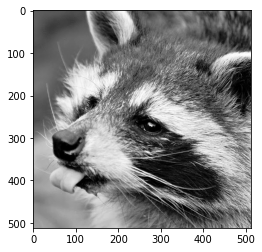

In [5]:
from scipy import misc
import matplotlib.cm as cm

# pip3 install pillow
from PIL import Image
import numpy as np
l = np.asarray(plt.imread("raccoon.jpg"))
# converts the image to grayscale
x = np.zeros((512,512),dtype=np.uint8)
for i in range(512):
    for j in range(512):
        x[i][j] = l[i][j][0]*0.299+l[i][j][1]*0.587+l[i][j][2]*0.113

plt.imshow(x, cmap = cm.Greys_r)

**a. Break up the image shown below into $1024$ chunks of size $256$ each.** Hint: You should only need one line for this part.

In [6]:
tt = x.reshape(1,512*512)[0]
size_of_packet = 256 
num_of_packets = 1024
assert len(tt) == size_of_packet * num_of_packets

# BEGIN YOUR SOLUTION
chunks = tt.reshape((num_of_packets,size_of_packet))
# END YOUR SOLUTION

Here's a function that simulates the transmission of data across the channel. It returns a tuple containing the total number of packets sent, the intermediate image every 512 packets and the final image, and the number of chunks decoded every 64 packets). You'll use it for the next question.

In [7]:
# Returns a tuple (packets sent, intermediate image every 512 packets + final image, chunks decoded every 64 packets)
def send(tx, rx, verbose=False):
    threshold = rx.num_chunks * 20
    num_sent = 0
    images = []
    chunks_decoded = []
    while not rx.isDone():
        tx.transmit_one_packet(num_sent)
        rx.receive_packet()
        if num_sent % 512 == 0:
            images.append(np.array(rx.chunks.reshape((512,512))))
            if verbose:
                print(num_sent, rx.chunksDone())
        if num_sent % 64 == 0:
            chunks_decoded.append(rx.chunksDone())
        num_sent += 1
        if num_sent > threshold:
            print("Ending transmission because too many packets have been sent. This may be caused by a bug in " + 
                  "receive_packet or an inefficient custom strategy.")
            break
            
    chunks_decoded.append(rx.chunksDone())
    images.append(rx.chunks.reshape((512,512)))
    return (num_sent, images, chunks_decoded)

**b. Using the 'single' degree distribution defined in the Transmitter class, send the raccoon over a channel with erasure probability 0.2.**  How many packets did you need to send?

The number of packets sent: 7994


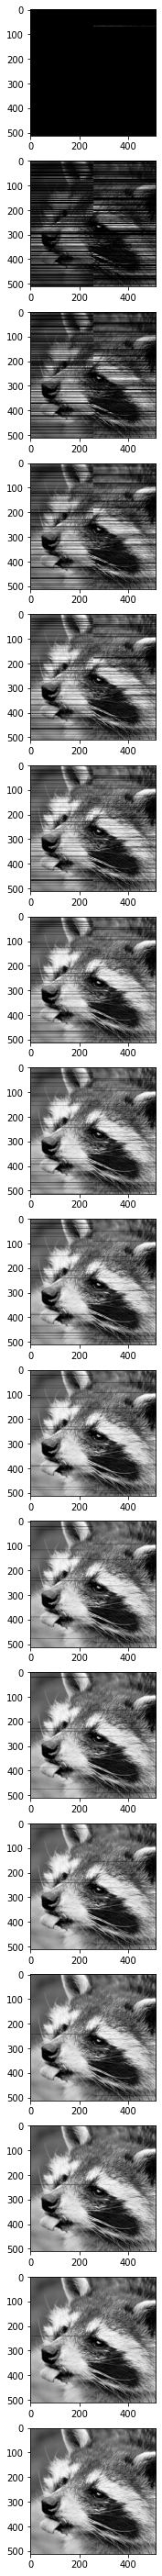

In [8]:
# BEGIN YOUR SOLUTION
# Set the below values to setup the channel
eps = 0.2
ch = Channel(eps)
tx = Transmitter(chunks, ch, 'single')
rx = Receiver(len(chunks), ch)
# END YOUR SOLUTION

single_sent, images, single_decoded = send(tx,rx)

print("The number of packets sent: {}".format(single_sent))

n_of_figures = len(images)
fig = plt.figure(figsize=(8, 3*n_of_figures))

for i in range(n_of_figures):
    fig.add_subplot(n_of_figures,1,i+1)
    plt.imshow(images[i], cmap = cm.Greys_r)

**c. Plot the number of chunks decoded as a function of the number of packets you send. (The chunks_decoded array should be helpful here)**

Text(0, 0.5, 'Number of chunks decoded')

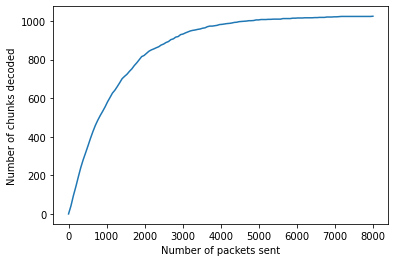

In [9]:
# BEGIN YOUR SOLUTION
plt.plot(list(range(0,single_sent,64))+[single_sent],single_decoded)
plt.xlabel("Number of packets sent")
plt.ylabel("Number of chunks decoded")
# END YOUR SOLUTION

**d. Looking at the graph, we see that it gets harder and harder to find the rest as we decode more and more chunks. Does this remind you of a well known theoretical problem?**

Hint: Try out some small examples!

**Coupon Collector Problem**

**e. Using the 'double' degree distribution defined in the Transmitter class, send the raccoon over a channel with erasure probability 0.2. Don't worry about intermediate plots this time. What happens?**

In [10]:
# BEGIN YOUR SOLUTION
eps = 0.2
ch = Channel(eps)
tx = Transmitter(chunks, ch, 'double')
rx = Receiver(len(chunks), ch)
# END YOUR SOLUTION

double_sent, images, double_decoded = send(tx,rx)
print("The number of packets received: {}".format(double_sent))

Ending transmission because too many packets have been sent. This may be caused by a bug in receive_packet or an inefficient custom strategy.
The number of packets received: 20481


**It stalls because there is a never a singleton packet. Therefore, in this case, our current algorithm can't solve for anything.**

## Q3. Randomized Distributions

**a. You have seen two degree distributions so far.  Both of these have been deterministic, and one worked better than the other.  Let's try a different degree distribution.  Using the 'baseline' degree distribution, send the raccoon over a channel with erasure probability 0.2 over multiple trials. For each trial, record the number of packets sent for the image to be decoded. Then, plot this as a histogram.**

[3188, 3586, 3170, 2828, 2652, 4658, 3504, 2764, 3983, 3615, 3008, 3427, 3329, 3284, 2876, 3218, 2438, 3099, 3584, 3026, 3174, 2642, 2633, 2608, 2714, 3514, 2880, 3608, 3402, 4558, 4196, 3116, 3101, 3063, 3942, 3212, 3555, 3529, 2876, 3128, 3359, 3158, 2891, 2746, 3662, 2792, 3367, 3131, 3304, 3933, 3230, 2703, 2926, 2509, 3244, 3391, 2980, 2624, 3502, 3573, 3874, 2966, 3306, 3109, 3770, 2952, 3067, 2832, 2794, 2780, 4315, 2951, 2605, 3281, 2682, 2988, 2976, 2894, 3384, 3597, 2829, 3967, 2715, 3613, 3877, 3050, 3170, 2906, 2622, 3946, 3120, 2847, 3369, 2869, 3333, 2718, 2497, 2773, 3632, 3134]


(array([10., 19., 17., 19., 13., 10.,  8.,  1.,  1.,  2.]),
 array([2438., 2660., 2882., 3104., 3326., 3548., 3770., 3992., 4214.,
        4436., 4658.]),
 <a list of 10 Patch objects>)

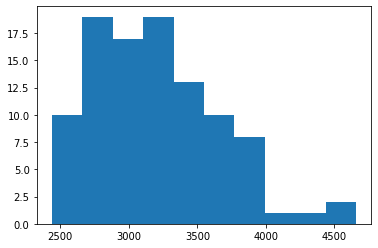

In [11]:
num_trials = 100
# BEGIN YOUR SOLUTION
eps = 0.2
ch = Channel(eps)
tx = Transmitter(chunks, ch, 'baseline')
# END YOUR SOLUTION

packets_required = []

for _ in range(num_trials):
    # BEGIN YOUR SOLUTION
    rx = Receiver(len(chunks), ch)
    baseline_sent, images, baseline_decoded = send(tx,rx)
    packets_required.append(baseline_sent)
    # END YOUR SOLUTION
    
# Plot this as a histogram
# BEGIN YOUR SOLUTION
print(packets_required)
plt.hist(packets_required)
# END YOUR SOLUTION

**b. Let's examine one final degree distribution. Using the 'sd' degree distribution, send the image over a channel with erasure probability 0.2. Plot the number of packets decoded against the number of packets transmitted.**

/home/kzl/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/kzl/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


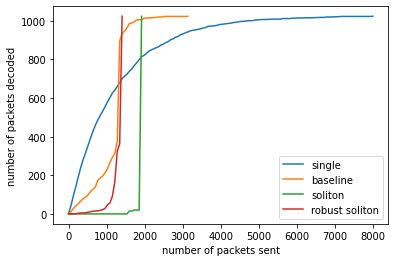

In [12]:
eps = 0.2
ch = Channel(eps)
tx_soliton = Transmitter( chunks, ch, 'sd')
tx_robust = Transmitter( chunks, ch, 'robust_sd', 0.1, 0.05 )
tx_deterministic = Transmitter (chunks, ch, 'deterministic', 0)

soliton_decoded, robust_decoded, deterministic_decoded = [], [], []

rx = Receiver(len(chunks), ch)
soliton_sent, images, soliton_decoded = send(tx_soliton, rx)
    
rx = Receiver(len(chunks), ch)
robust_sent, images, robust_decoded = send(tx_robust, rx)
    
# Set the aspect ratio such that the image is wide
# width, height = plt.figaspect(0.2)
# fig = plt.figure(figsize=(width,height))
# plt.figure()
plt.plot(range(0,single_sent+64,64), single_decoded, label="single")
plt.plot(range(0,baseline_sent+64,64), baseline_decoded, label="baseline")
plt.plot(range(0,soliton_sent+64,64), soliton_decoded, label="soliton")
plt.plot(range(0,robust_sent+64,64), robust_decoded, label="robust soliton")
plt.legend()
plt.xlabel("number of packets sent")
plt.ylabel("number of packets decoded")
plt.show()

The codes we asked you to look at and create are known generally as *fountain codes*.  As you have seen above, we implemented two types of degree distributions: soliton and robust soliton.  It turns out that the soliton distribution, which was discovered and named by the creator of LT Codes, Michael Luby, is ideal in expectation.  It seems that it would be most beneficial for there to be one check node with degree $1$ at each iteration.  In expectation, the ideal soliton distribution achieves this.  Unfortunately in practice, it fares much more poorly.  To account for that, we use what is called the *robust soliton distribution*.  

- Soliton:
$$
 \rho(d) =
  \begin{cases} 
      \hfill \frac{1}{K}    \hfill & \text{ if $d = 1$} \\
      \hfill \frac{1}{d(d-1)} \hfill & \text{ if $d = 2,3,...,K$}
  \end{cases}
$$

- Robust Soliton:  $\mu(d) = \frac{\rho(d) + \tau(d)}{\sum_{k}\rho(k) + \tau(k)}$

where
$$
 \tau(d) =
  \begin{cases} 
      \hfill \frac{S}{K} \cdot \frac{1}{d}    \hfill & \text{ if $d < K/S$} \\
      \hfill \frac{S}{K}\ln{(\frac{S}{\delta})} \hfill & \text{ if $d = K$} \\
      \hfill 0 \hfill & \text{ if $d > K/S$} \\
  \end{cases}
$$

and $S= c\ln{(\frac{K}{\delta})}\sqrt{K}$.  For more information, please see [1].  

## Q4. Competition Model

In [13]:
from math import floor

def score(chunks_decoded):
    c_d = chunks_decoded
    s = c_d[8]/512+c_d[16]/1024
    arr = [33,65,97]
    for i in arr:
        if i >= len(c_d):
            s += 1
    return s

Technically, if you are allowed to deterministically choose whick chunks to send, the best thing to do is to send each of the 1024 chunks as individual packets. That would lead to a decode rate of $1-eps = 0.8$, which is optimal since no redundant information is sent. After sending the first 1024, if you modify robust soliton distribution, you can still everything within the next 1024, leading the roughly a score of 4.6.

However, since we specified to only create a degree distribution, one good idea you could do is send a bunch of singletons (say 512) in the beginning and then use modify the robust soliton distribution for the rest. To adjust for the fact that you are sending a lot of singletons in the beginning, you could linearly scale the robust soliton distribution so that it sends packets of higher degree more. You should still prechoose the degrees to send and importantly, sort them in ascending order to maximize early decodes. This, shown below, gets a score of roughly 4.2.

Score: 4.2154296875
Sent: 2029.5
2020


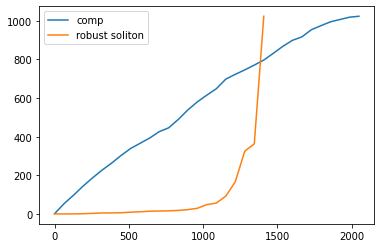

In [14]:
eps = 0.2
ch = Channel(eps)

s = 0
avg = 0
trials = 100
for i in range(trials):
    tx_competition = Transmitter(chunks, ch, 'competition', 0.1, 0.05)
    rx = Receiver(len(chunks), ch)
    comp_sent, images, comp_decoded = send(tx_competition,rx)
    s += score(comp_decoded)
    avg += comp_sent
print("Score: {}".format(s/trials))
print("Sent: {}".format(avg/trials))

plt.plot(range(0,comp_sent+64,64), comp_decoded, label="comp")
plt.plot(range(0,robust_sent+64,64), robust_decoded, label="robust soliton")
plt.legend()
print(comp_sent)

### Results

- **Report the average score (averaged over 10 trials)**: 4.23
- **Report the names of your teammates**: TEAMMATES

## References
[1] D. Mackay.  Information Theory, Inference, and Learning Algorithms. 2003 <br>
[2] http://blog.notdot.net/2012/01/Damn-Cool-Algorithms-Fountain-Codes